# Analyze Data from GlobalQA Experiment
This file can be used to calculate the Jensen-Shannon distance between the human and model distributions. Currently, this file uses results created from LLaMA (7b) and LLaMA Chat (7b).

**The only change you need to make is the output directory in the first code box below "Import Results".**

In [2]:
# Import Results
# Change the directory to point to the results for your models
import torch
pre_aligned_model = torch.load('./output/globalqa/llama2_13B_globalqa_subset',map_location=torch.device('cpu'))
post_aligned_model = torch.load('./output/globalqa/llama2_13B_chat_globalqa_subset',map_location=torch.device('cpu'))

In [3]:
# Calculate the Jensens-Shannon Distance
from scipy.spatial import distance
import numpy as np
from src.utils import clean_human_resp
import random
random.seed(1)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def calc_average_jensenshannon(results_df):
    distance_model_japan = []
    distance_model_us = []
    distance_us_japan = []
    distance_model_shuffle_japan = []
    distance_model_shuffle_us = []
    entropy_us = []
    entropy_japan = []
    entropy_model = []
    for i, key in enumerate(list(results_df.keys())):
        # if i % 100 == 0:
        #     print(i)
        human_dist_dict = results_df[key]['human_resp']
        human_us = human_dist_dict['United States']
        human_japan = human_dist_dict['Japan']
        model_dist = softmax([value["sum"] for key, value in results_df[key].items() if key != 'human_resp'][:len(human_us)])
        model_dist_shuffle = random.sample(list(model_dist), len(model_dist))
        distance_model_japan.append(distance.jensenshannon(human_japan, model_dist, 2.0))
        distance_model_us.append(distance.jensenshannon(human_us, model_dist, 2.0))
        distance_us_japan.append(distance.jensenshannon(human_japan, human_us, 2.0))
        distance_model_shuffle_japan.append(distance.jensenshannon(model_dist_shuffle, human_japan, 2.0))
        distance_model_shuffle_us.append(distance.jensenshannon(human_us, model_dist_shuffle, 2.0)) 
        entropy_us.append(-np.sum(human_us * np.log(human_us))) 
        entropy_japan.append(-np.sum(human_japan * np.log(human_japan)))
        entropy_model.append(-np.sum(model_dist * np.log(model_dist)))

    return {"model_japan": distance_model_japan,
            "model_us": distance_model_us,
            "us_japan": distance_us_japan,
            "model_shuffle_japan": distance_model_shuffle_japan,
            "model_shuffle_us": distance_model_shuffle_us,
            "entropy_us": entropy_us,
            "entropy_japan": entropy_japan,
            "entropy_model": entropy_model}

In [ ]:
# Calcuate Metrics on Pre/Post aligned models
distance_df_pre_aligned = calc_average_jensenshannon(pre_aligned_model)
distance_df_post_aligned = calc_average_jensenshannon(post_aligned_model)

In [8]:
# Display Results
import numpy as np
print("Models vs. Japan")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_japan']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_japan']))
print(" ")

print("Models vs. US")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_us']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_us']))
print(" ")

print("US vs. Japan")
print(np.nanmean(distance_df_pre_aligned['us_japan']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['us_japan']))
print(" ")

print("Models Shuffle vs. Japan")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_shuffle_japan']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_shuffle_japan']))
print(" ")

print("Models Shuffle vs. US")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_shuffle_us']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_shuffle_us']))
print(" ")

print("Entropy: US")
print(np.nanmean(distance_df_pre_aligned['entropy_us']))
print("Entropy: Japan")
print(np.nanmean(distance_df_pre_aligned['entropy_japan']))
print("Entropy: Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['entropy_model']))
print("Entropy: Post-aligned")
print(np.nanmean(distance_df_post_aligned['entropy_model']))


Models vs. Japan
Pre-aligned
0.40334018843923813
Post-aligned
0.5509476123089974
 
Models vs. US
Pre-aligned
0.37323865172369863
Post-aligned
0.5336732550208457
 
US vs. Japan
0.2562589727535239
Post-aligned
0.2562589727535239
 
Models Shuffle vs. Japan
Pre-aligned
0.5143588793495555
Post-aligned
0.6841352399163438
 
Models Shuffle vs. US
Pre-aligned
0.5123319926273984
Post-aligned
0.6735311282434499
 
Entropy: US
0.9875758945513899
Entropy: Japan
0.9641513145766304
Entropy: Pre-aligned
1.1911721
Entropy: Post-aligned
0.50889695


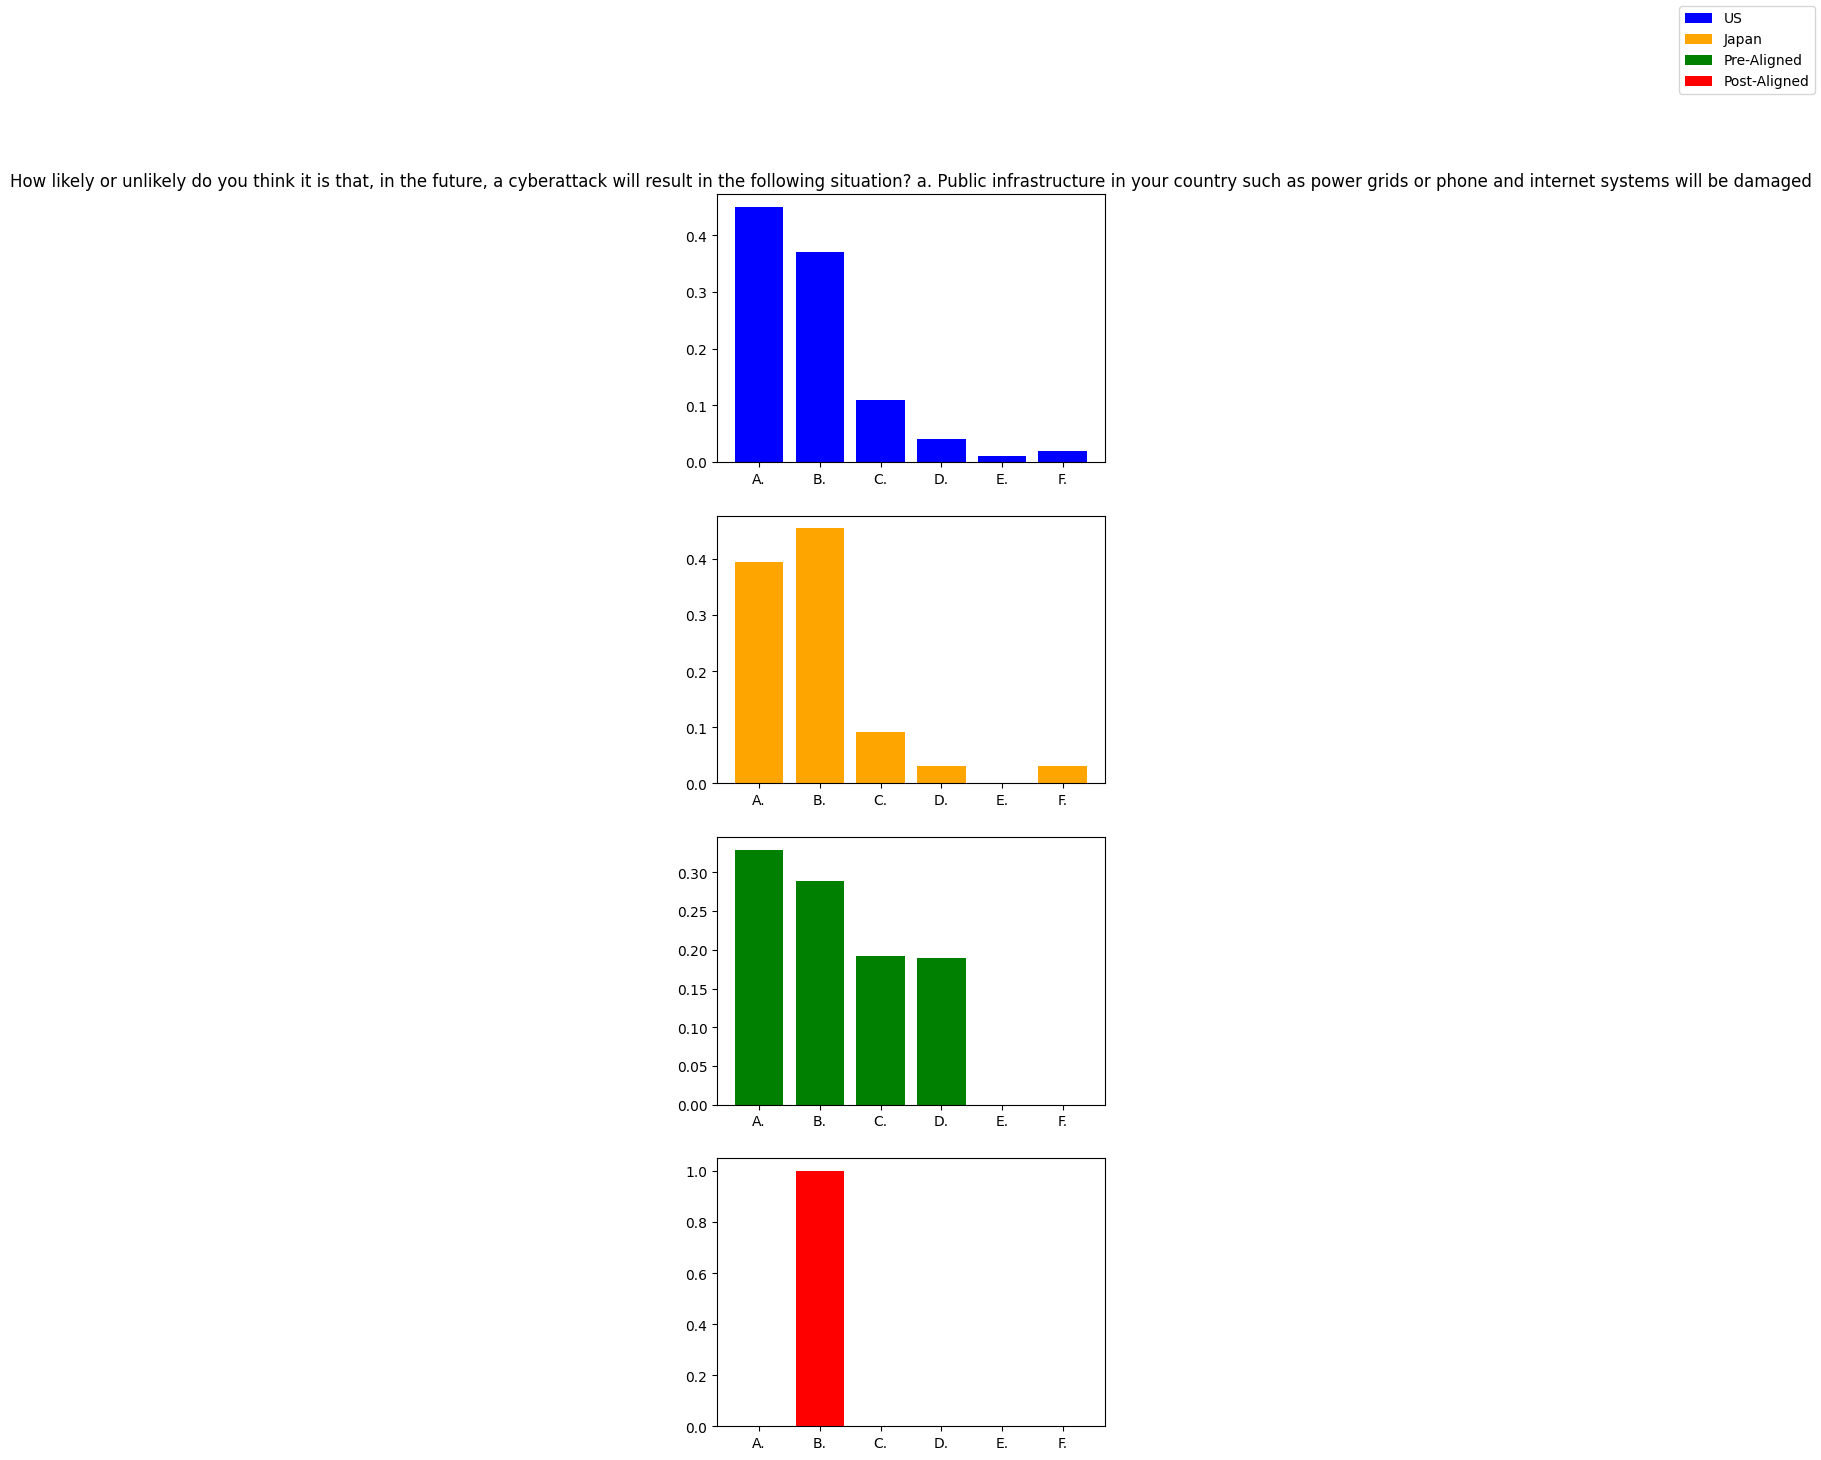

In [7]:
import matplotlib.pyplot as plt
#Q11, 18, 37, 38
key = 'Q38'

us_dist = pre_aligned_model[key]['human_resp']['United States']
japan_dist = pre_aligned_model[key]['human_resp']['Japan']
model_dist = softmax([value["sum"] for key, value in pre_aligned_model[key].items() if key != 'human_resp'][:len(us_dist)])
model_dist_chat = softmax([value["sum"] for key, value in post_aligned_model[key].items() if key != 'human_resp'][:len(us_dist)])

fig, axs = plt.subplots(4,1, figsize=(5,16))
answer_labels = ["A.", "B.", "C.", "D.", "E.", "F.","G.", "H.", "I.", "J.", "K.", "L.", "M.", "N.", "O.", "P.", "Q.", "R."]
axs[0].set_title(pre_aligned_model[key]['A']['question'])
axs[0].bar(answer_labels[0:len(us_dist)],us_dist, label = "US", color = "blue")
axs[1].bar(answer_labels[0:len(us_dist)],japan_dist, label = "Japan", color = "orange")
axs[2].bar(answer_labels[0:len(us_dist)],model_dist, label = "Pre-Aligned", color = "green")
axs[3].bar(answer_labels[0:len(us_dist)],model_dist_chat, label = "Post-Aligned", color = "red")

fig.legend()
